<a href="https://colab.research.google.com/github/Vish212121/Sentiment-Analysis-of-Financial-News-for-Stock-Market/blob/main/Sentiment_Analysis_of_Financial_News_for_Stock_Market_Prediction_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import random
import seaborn as sns
import requests
import zipfile
import os

# NEW IMPORTS - Add these to your existing Cell 2
import yfinance as yf
from bs4 import BeautifulSoup
import spacy
from difflib import SequenceMatcher
from datetime import datetime, timedelta
import time
import pickle
!pip install matplotlib seaborn plotly
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# Install required packages (run these first)
!pip install yfinance beautifulsoup4 spacy
!python -m spacy download en_core_web_sm

nltk.download('stopwords')
print("Tensorflow Version", tf.__version__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 44.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Tensorflow Version 2.18.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
df = pd.read_csv('stock_data.csv', encoding='latin', header=None)
df1 = df.iloc[1:]
df.drop(index=df.index[0], axis=0, inplace=True)
df.columns = ['text', 'sentiment']

# Label decoding
lab_to_sentiment = {"-1": "Negative", "1": "Positive"}
def label_decoder(label):
    y = lab_to_sentiment.get(label)
    if y is not None:
        return y
    else:
        return "Unknown"

df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))

# Display first few rows
df.head()

,text,sentiment
1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,Positive
2,user: AAP MOVIE. 55% return for the FEA/GEED i...,Positive
3,user I'd be afraid to short AMZN - they are lo...,Positive
4,MNTA Over 12.00,Positive
5,OI Over 21.37,Positive


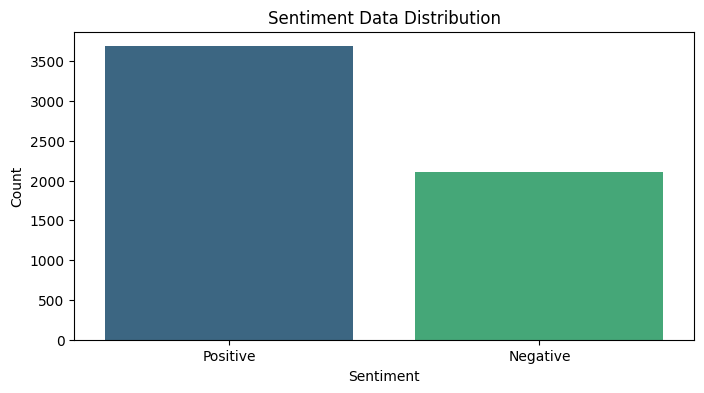

,text,sentiment
400,"user jemberlin that is my number too, will be ...",Negative
3801,"TIP is getting trippy, boss.",Positive
3634,"SAVE continues run, all-time high within sight...",Positive
1539,YHOO Yahoo is a iberal hangout. History shows...,Negative
947,"also not very healthy, fell back below DT lin...",Negative
5236,The stricken Bank of Jinzhou will unload $21 b...,Positive
3622,DDD also following through nicely from yesterd...,Negative
282,FME: ong 10.25. Trailing Stop 13.75 from 8 p...,Positive
2585,MITK - been waiting for pullback since 4.00 no...,Positive
70,"FOD should see a solid move up tom, system pre...",Positive


In [54]:
val_count = df.sentiment.value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=val_count.index, y=val_count.values, hue=val_count.index, palette="viridis", dodge=False, legend=False)
plt.title("Sentiment Data Distribution")
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Display random samples
random_idx_list = [random.randint(1, len(df.text)) for _ in range(10)]
df.loc[random_idx_list, :].head(10)

In [55]:
# Define stopwords and stemmer
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

# Preprocessing function
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

df.text = df.text.apply(lambda x: preprocess(x))

# Display first few rows after preprocessing
df.head()

,text,sentiment
1,kickers watchlist xide tit soq pnk cpw bpz aj ...,Positive
2,user aap movie 55 return fea geed indicator 15...,Positive
3,user afraid short amzn looking like near monop...,Positive
4,mnta 12 00,Positive
5,oi 21 37,Positive


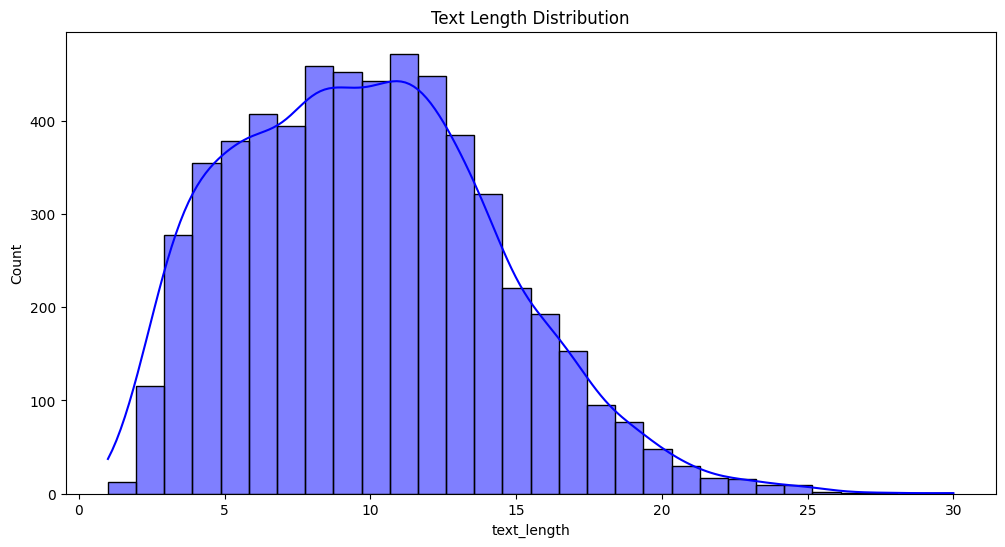

In [56]:
df['text_length'] = df.text.apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
sns.histplot(df['text_length'], kde=True, bins=30, color='blue')
plt.title("Text Length Distribution")
plt.show()

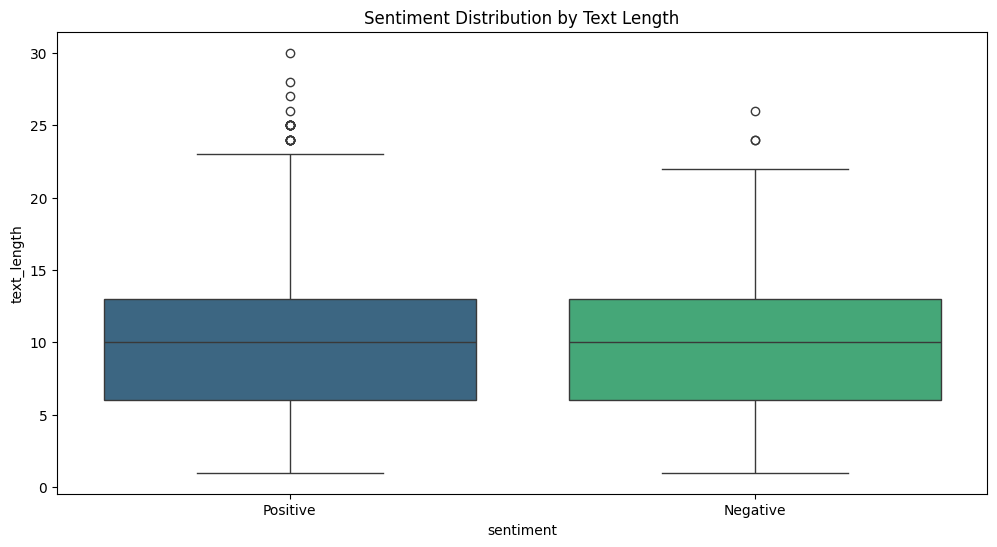

In [57]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='sentiment', y='text_length', data=df, hue='sentiment', palette="viridis", legend=False)
plt.title("Sentiment Distribution by Text Length")
plt.show()

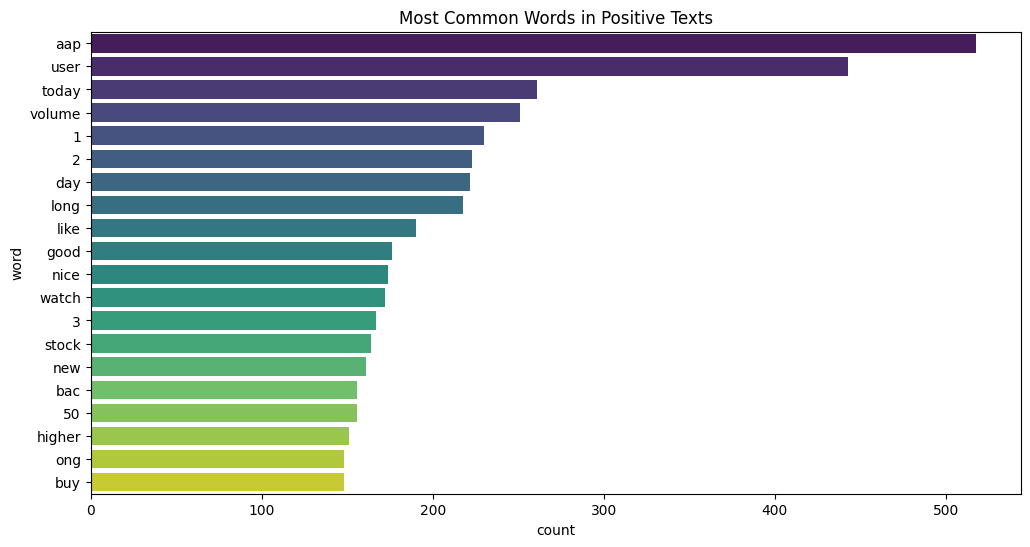

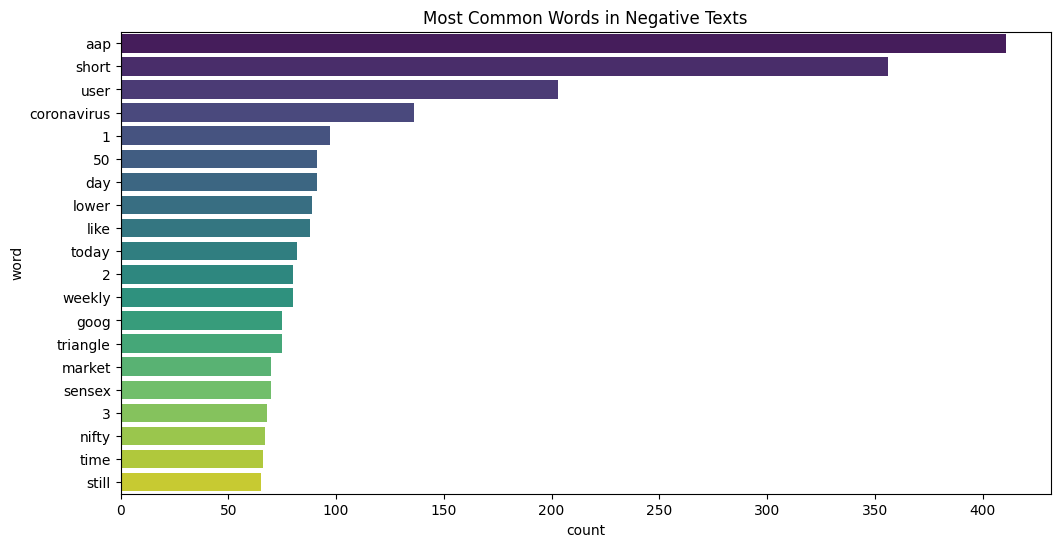

In [58]:
from collections import Counter

# Function to plot the most common words
def plot_most_common_words(text, sentiment):
    words = ' '.join(text).split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(20)

    df_common_words = pd.DataFrame(common_words, columns=['word', 'count'])

    plt.figure(figsize=(12, 6))
    sns.barplot(x='count', y='word', hue='word', dodge=False, data=df_common_words, palette='viridis', legend=False)
    plt.title(f'Most Common Words in {sentiment} Texts')
    plt.show()

# Plot most common words for positive texts
plot_most_common_words(df[df.sentiment == 'Positive'].text, 'Positive')

# Plot most common words for negative texts
plot_most_common_words(df[df.sentiment == 'Negative'].text, 'Negative')

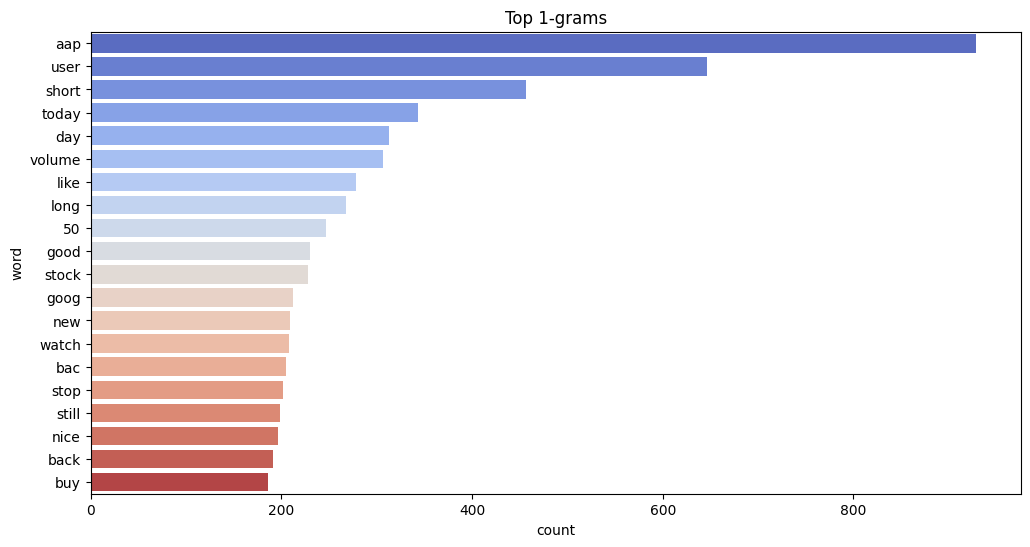

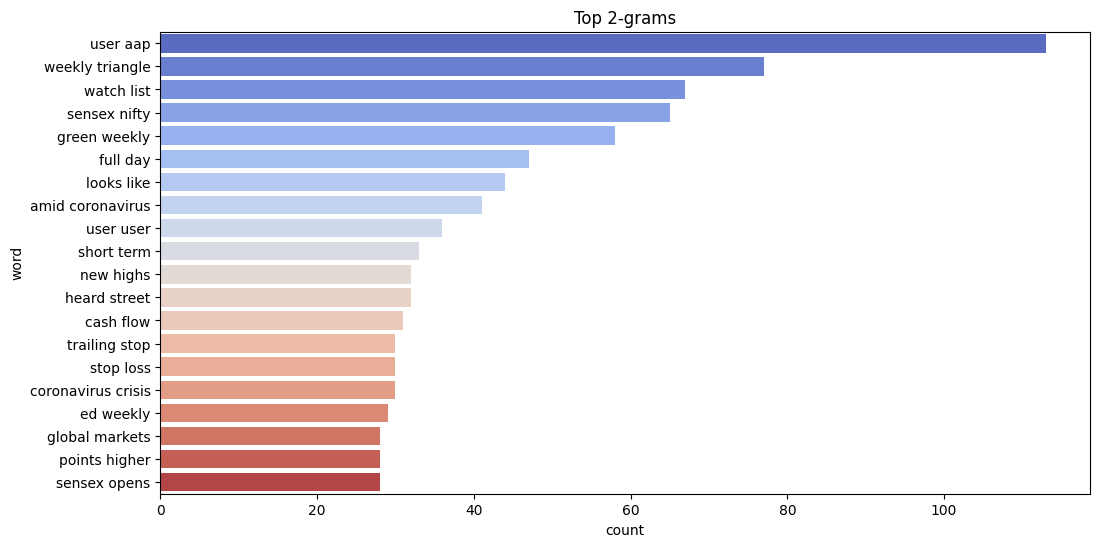

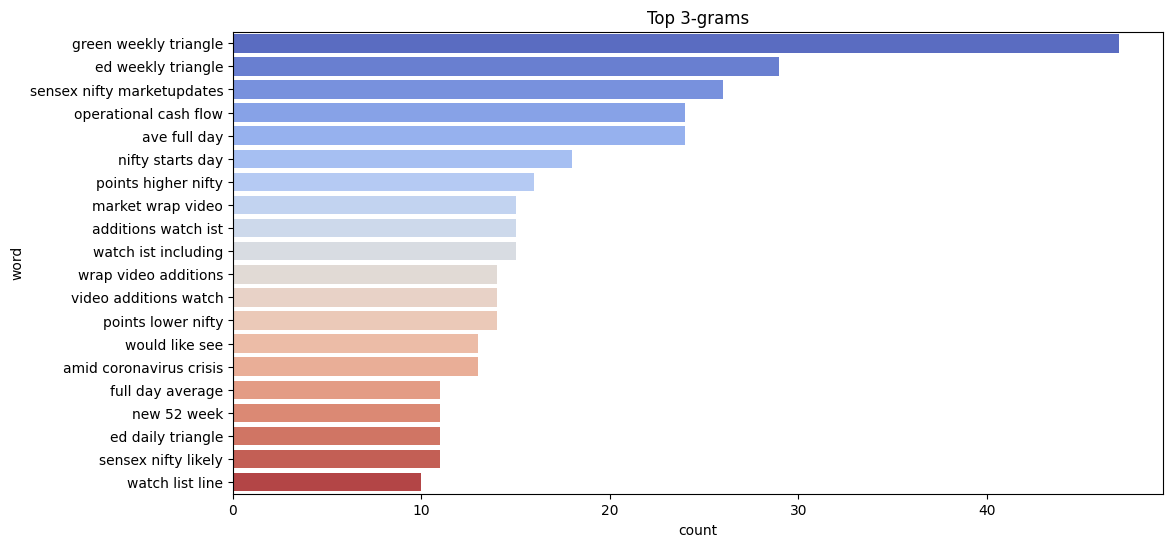

In [59]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to plot top n-grams
def plot_top_ngrams(text, n, title):
    vec = CountVectorizer(ngram_range=(n, n)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    df_ngrams = pd.DataFrame(words_freq[:20], columns=['word', 'count'])

    plt.figure(figsize=(12, 6))
    sns.barplot(x='count', y='word', hue='word', dodge=False, data=df_ngrams, palette='coolwarm', legend=False)
    plt.title(f'Top {n}-grams')
    plt.show()

# Plot top unigrams (1-grams)
plot_top_ngrams(df.text, 1, 'Top Unigrams')

# Plot top bigrams (2-grams)
plot_top_ngrams(df.text, 2, 'Top Bigrams')

# Plot top trigrams (3-grams)
plot_top_ngrams(df.text, 3, 'Top Trigrams')

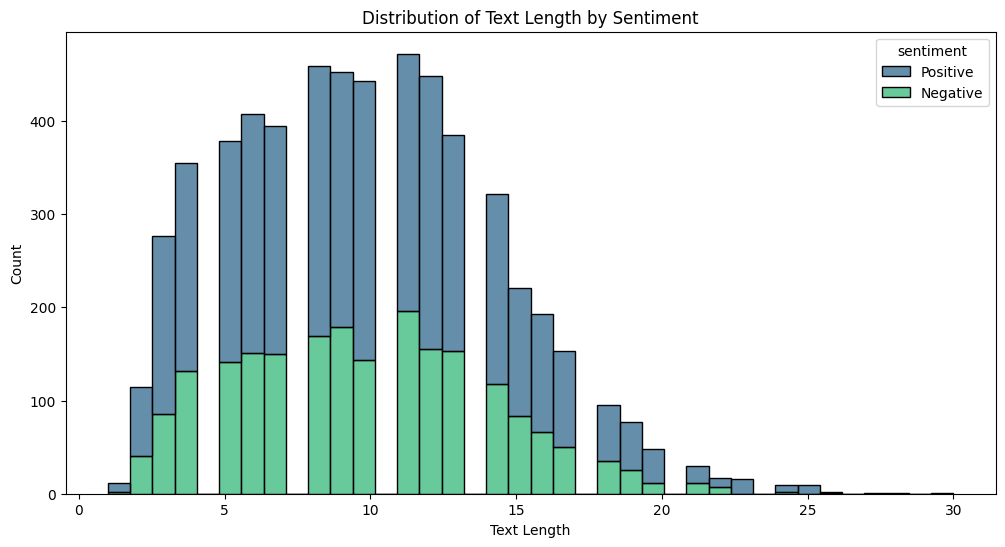

In [60]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='sentiment', multiple='stack', palette='viridis')
plt.title('Distribution of Text Length by Sentiment')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

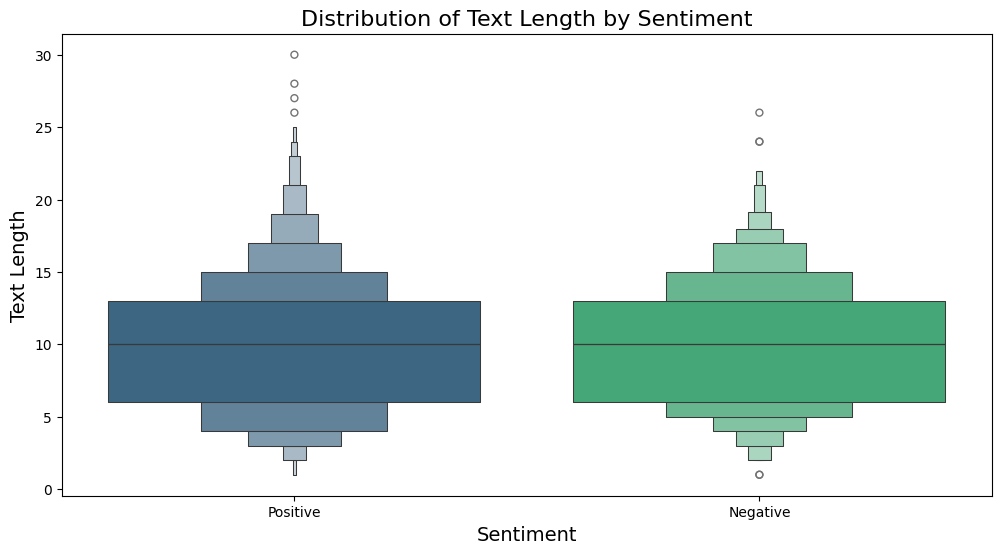

In [61]:
plt.figure(figsize=(12, 6))
sns.boxenplot(x='sentiment', y='text_length', hue='sentiment', palette='viridis', dodge=False, legend=False, data=df)
plt.title('Distribution of Text Length by Sentiment', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Text Length', fontsize=14)
plt.show()

In [62]:
TRAIN_SIZE = 0.8
MAX_SEQUENCE_LENGTH = 30

# Split the data
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=7)
print("Train Data size:", len(train_data))
print("Test Data size:", len(test_data))

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size:", vocab_size)

# Pad the sequences
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen=MAX_SEQUENCE_LENGTH)

print("Training X Shape:", x_train.shape)
print("Testing X Shape:", x_test.shape)

# Encode the labels
labels = train_data.sentiment.unique().tolist()
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Train Data size: 4632
Test Data size: 1159
Vocabulary Size: 7947
Training X Shape: (4632, 30)
Testing X Shape: (1159, 30)
y_train shape: (4632, 1)
y_test shape: (1159, 1)


In [63]:
# Path to save the GloVe zip file
zip_path = os.path.join("Documents", "Deep Learning", "NLP", "stocks", "glove.6B.zip")
extracted_path = os.path.join("Documents", "Deep Learning", "NLP", "stocks")

# URL of the GloVe embeddings
url = "http://nlp.stanford.edu/data/glove.6B.zip"

# Create directories if they don't exist
os.makedirs(extracted_path, exist_ok=True)

# Download the file
response = requests.get(url, stream=True)
with open(zip_path, "wb") as f:
    for chunk in response.iter_content(chunk_size=128):
        f.write(chunk)

# Unzip the file
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extracted_path)

# Path to the extracted GloVe file
GLOVE_EMB = os.path.join(extracted_path, "glove.6B.300d.txt")
if not os.path.exists(GLOVE_EMB):
    raise FileNotFoundError(f"File not found: {GLOVE_EMB}")

# Load the GloVe embeddings
embeddings_index = {}

with open(GLOVE_EMB, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

# Create the embedding matrix
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create the embedding layer
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],
                                            trainable=False)

Found 400000 word vectors.


In [64]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Define additional parameters
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

# Define the model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
reduce_lr = ReduceLROnPlateau(factor=0.1, min_lr=0.01, monitor='val_loss', verbose=1)

# Train the model
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[reduce_lr])

Training on CPU...
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5740 - loss: 0.6772 - val_accuracy: 0.6428 - val_loss: 0.6479 - learning_rate: 0.0010
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 814ms/step - accuracy: 0.6315 - loss: 0.6545 - val_accuracy: 0.6428 - val_loss: 0.6406 - learning_rate: 0.0010
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 784ms/step - accuracy: 0.6379 - loss: 0.6363 - val_accuracy: 0.6428 - val_loss: 0.6199 - learning_rate: 0.0010
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 798ms/step - accuracy: 0.6387 - loss: 0.6088 - val_accuracy: 0.6652 - val_loss: 0.6036 - learning_rate: 0.0010
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6845 - loss: 0.5836 - val_accuracy: 0.6557 - val_loss: 0.5985 - learning_rate: 0.0010
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 758ms/step - accuracy: 0.7115 - loss: 0.5632 - val_accuracy: 0.6851 - val_loss: 0.5869 - learning_rate: 0.0010
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 800ms/step - accuracy: 0.7385 - loss: 0.5267 - 

In [65]:
# Step 1: Save the trained model
model.save("model.h5")

# Step 2: Save the tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model and tokenizer saved successfully!")


Model and tokenizer saved successfully!


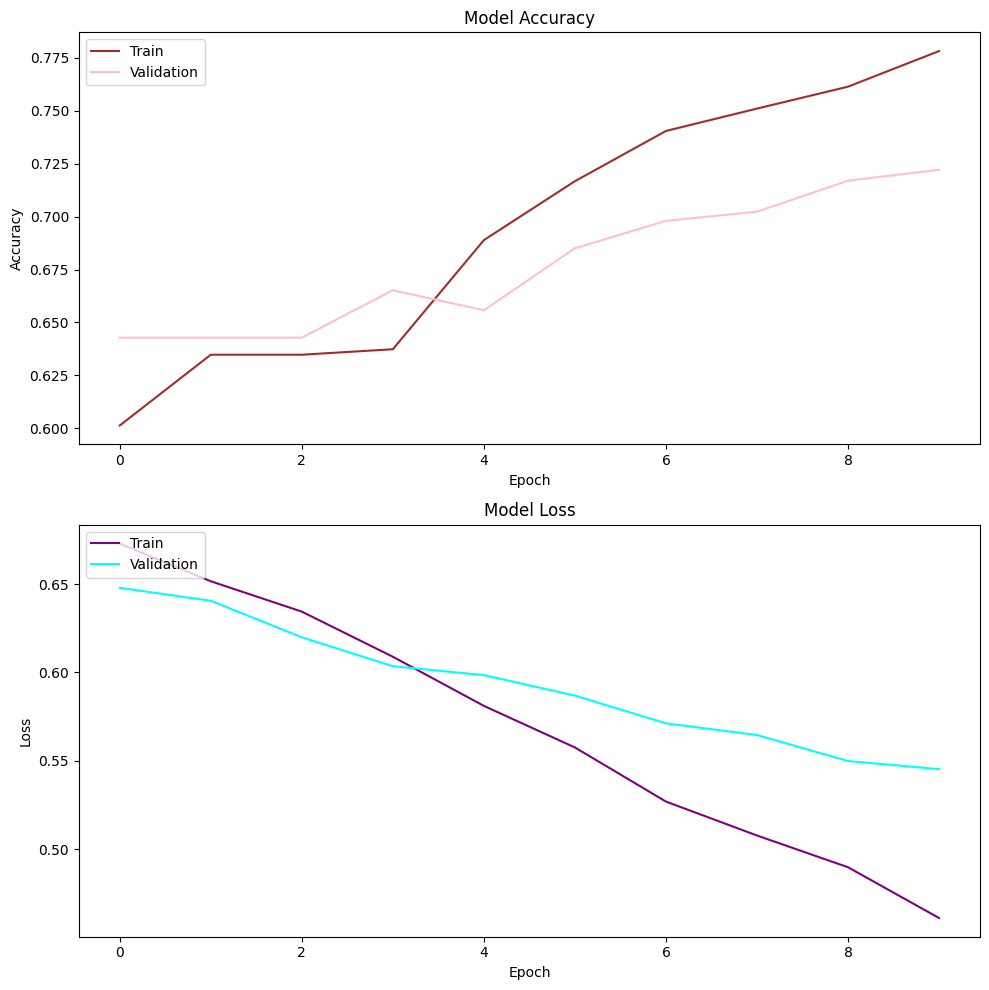

In [66]:
s, (at, al) = plt.subplots(2, 1, figsize=(10, 10))
at.plot(history.history['accuracy'], c='brown')
at.plot(history.history['val_accuracy'], c='pink')
at.set_title('Model Accuracy')
at.set_ylabel('Accuracy')
at.set_xlabel('Epoch')
at.legend(['Train', 'Validation'], loc='upper left')

al.plot(history.history['loss'], c='purple')
al.plot(history.history['val_loss'], c='cyan')
al.set_title('Model Loss')
al.set_ylabel('Loss')
al.set_xlabel('Epoch')
al.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [67]:
# =============================================================================
# FINANCIAL NEWS SCRAPING AND ANALYSIS SYSTEM
# =============================================================================

# Load spaCy model for company extraction
nlp = spacy.load("en_core_web_sm")

# Financial news sources configuration
NEWS_SOURCES = {
    'reuters': 'https://www.reuters.com/markets/stocks/',
    'cnbc': 'https://www.cnbc.com/markets/',
    'yahoo_finance': 'https://finance.yahoo.com/news/',
}

# Company to ticker mapping (expand this list as needed)
COMPANY_TICKER_MAP = {
    'Apple': 'AAPL', 'Microsoft': 'MSFT', 'Amazon': 'AMZN',
    'Google': 'GOOGL', 'Tesla': 'TSLA', 'Meta': 'META',
    'Netflix': 'NFLX', 'Nvidia': 'NVDA', 'JPMorgan': 'JPM',
    'Goldman Sachs': 'GS', 'Bank of America': 'BAC',
    'Walmart': 'WMT', 'Johnson': 'JNJ', 'Visa': 'V'
}

COMPANY_SUFFIXES = ['Inc', 'Corp', 'Ltd', 'LLC', 'Co', 'Company', 'Corporation']
TICKER_PATTERN = re.compile(r'\b[A-Z]{2,5}\b')

def scrape_financial_news(source='yahoo_finance', limit=20):
    """Scrape financial news headlines"""
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }

    articles = []
    try:
        if source == 'yahoo_finance':
            # Yahoo Finance news scraping
            url = 'https://finance.yahoo.com/topic/stock-market-news'
            response = requests.get(url, headers=headers)
            soup = BeautifulSoup(response.content, 'html.parser')

            # Find news headlines
            headlines = soup.find_all('h3', limit=limit)
            for headline in headlines:
                if headline.get_text().strip():
                    articles.append({
                        'title': headline.get_text().strip(),
                        'source': source,
                        'timestamp': datetime.now()
                    })

        # Add delay to be respectful
        time.sleep(2)

    except Exception as e:
        print(f"Error scraping {source}: {e}")
        # Fallback with sample headlines if scraping fails
        articles = [
            {'title': 'Apple stock rises on strong iPhone sales forecast', 'source': 'sample', 'timestamp': datetime.now()},
            {'title': 'Tesla deliveries disappoint Wall Street expectations', 'source': 'sample', 'timestamp': datetime.now()},
            {'title': 'Microsoft Azure cloud revenue beats estimates', 'source': 'sample', 'timestamp': datetime.now()},
            {'title': 'Amazon Prime Day drives strong quarterly results', 'source': 'sample', 'timestamp': datetime.now()},
            {'title': 'Netflix loses subscribers amid streaming competition', 'source': 'sample', 'timestamp': datetime.now()}
        ]

    return articles

print("✅ News scraping functions loaded successfully!")


✅ News scraping functions loaded successfully!


In [68]:
# =============================================================================
# COMPANY AND TICKER EXTRACTION FUNCTIONS
# =============================================================================

def extract_companies_from_text(text):
    doc = nlp(text)
    companies = []
    for ent in doc.ents:
        if ent.label_ == "ORG":
            companies.append(ent.text.strip())
    return {'companies': list(set(companies))}


def match_companies_to_tickers(companies):
    matched_tickers = []
    for company in companies:
        # Direct mapping
        for known_company, ticker in COMPANY_TICKER_MAP.items():
            if known_company.lower() in company.lower():
                matched_tickers.append(ticker)
    return list(set(matched_tickers))


def analyze_news_article(article_text, model, tokenizer):
    """Analyze single news article for sentiment and companies"""
    # Extract companies using NER
    entities = extract_companies_from_text(article_text)
    companies = entities['companies']
    # Match to tickers using your mapping (NOT extracting from text)
    tickers = [COMPANY_TICKER_MAP.get(c, '') for c in companies]
    # Remove empty / unmapped tickers
    tickers = [t for t in tickers if t]
    tickers = list(set(tickers))  # Remove duplicates

    # Preprocess text
    processed_text = preprocess(article_text, stem=True)
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)

    # Predict sentiment
    sentiment_score = model.predict(padded_sequence, verbose=0)[0][0]
    sentiment_label = "Positive" if sentiment_score > 0.5 else "Negative"
    confidence = abs(sentiment_score - 0.5) * 2

    return {
        'text': article_text,
        'companies': companies,
        'tickers': tickers,
        'sentiment_score': float(sentiment_score),
        'sentiment_label': sentiment_label,
        'confidence': float(confidence)
    }


print("✅ Company extraction functions loaded successfully!")


✅ Company extraction functions loaded successfully!


In [69]:
# =============================================================================
# STOCK PRICE INTEGRATION AND PREDICTION LOGIC
# =============================================================================

def get_stock_data(ticker, period='5d'):
    """Fetch recent stock price data"""
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(period=period)

        if hist.empty:
            return None

        current_price = hist['Close'].iloc[-1]
        previous_price = hist['Close'].iloc[-2] if len(hist) > 1 else current_price
        price_change = ((current_price - previous_price) / previous_price) * 100

        return {
            'ticker': ticker,
            'current_price': round(current_price, 2),
            'price_change_percent': round(price_change, 2),
            'volume': int(hist['Volume'].iloc[-1])
        }
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None

def predict_stock_movement(sentiment_score, confidence, price_change_percent=0):
    """Predict stock movement based on sentiment"""
    sentiment_impact = sentiment_score * confidence

    # Trend alignment
    trend_alignment = 1 if (sentiment_score > 0.5 and price_change_percent > 0) or \
                           (sentiment_score < 0.5 and price_change_percent < 0) else -0.5

    # Combined prediction score
    prediction_score = sentiment_impact * 0.7 + trend_alignment * 0.3

    if prediction_score > 0.65:
        return "STRONG BUY", prediction_score
    elif prediction_score > 0.55:
        return "BUY", prediction_score
    elif prediction_score > 0.45:
        return "HOLD", prediction_score
    elif prediction_score > 0.35:
        return "SELL", prediction_score
    else:
        return "STRONG SELL", prediction_score

def create_market_report(analyzed_articles):
    """Create comprehensive market report"""
    if not analyzed_articles:
        return "No articles to analyze"

    # Calculate overall market sentiment
    sentiments = [art['sentiment_score'] for art in analyzed_articles]
    overall_sentiment = sum(sentiments) / len(sentiments)

    # Group by ticker for recommendations
    ticker_analysis = {}
    for article in analyzed_articles:
        for ticker in article['tickers']:
            if ticker not in ticker_analysis:
                ticker_analysis[ticker] = []
            ticker_analysis[ticker].append(article)

    return {
        'total_articles': len(analyzed_articles),
        'overall_sentiment': overall_sentiment,
        'sentiment_label': 'Positive' if overall_sentiment > 0.5 else 'Negative',
        'ticker_analysis': ticker_analysis
    }

print("✅ Stock analysis functions loaded successfully!")


✅ Stock analysis functions loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


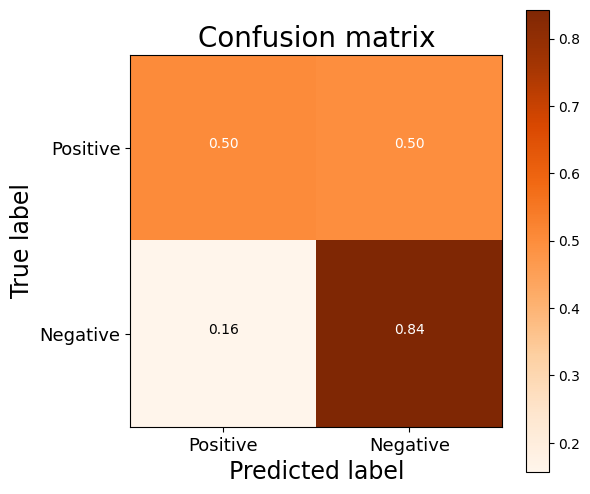

In [70]:
def decode_sentiment(score):
    return "Positive" if score > 0.5 else "Negative"

# Predict and decode sentiment
scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Oranges):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

# Compute and plot confusion matrix
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

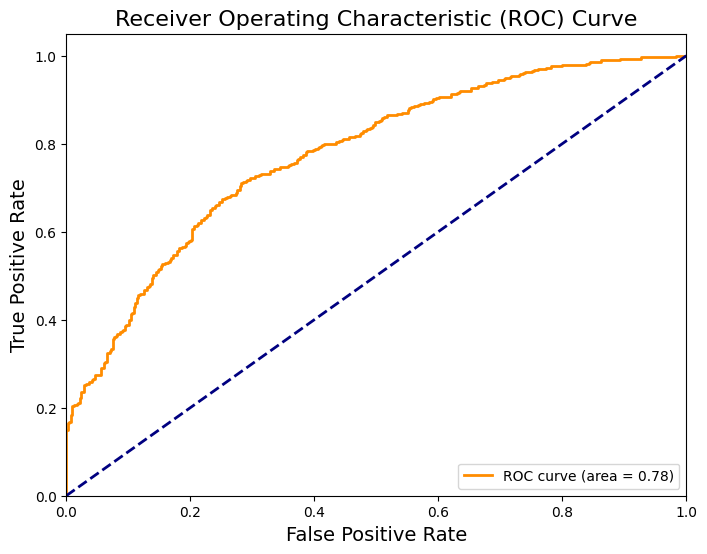

In [71]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.show()

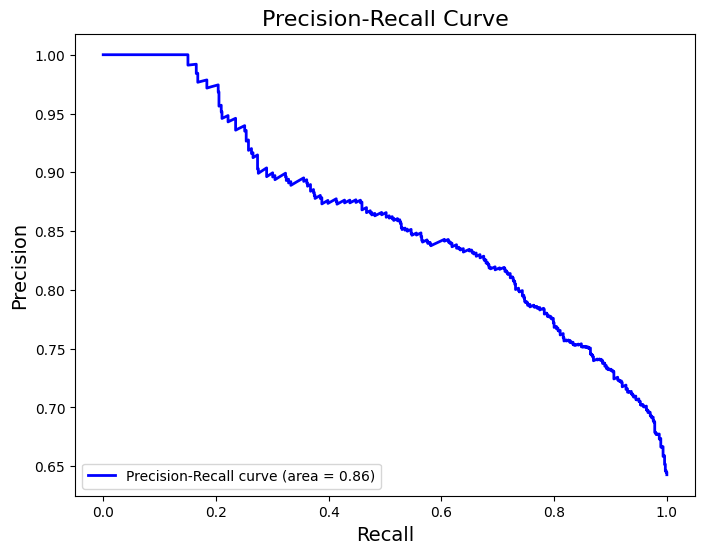

In [72]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve and average precision
precision, recall, _ = precision_recall_curve(y_test, scores)
average_precision = average_precision_score(y_test, scores)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {average_precision:0.2f})')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc="lower left")
plt.show()

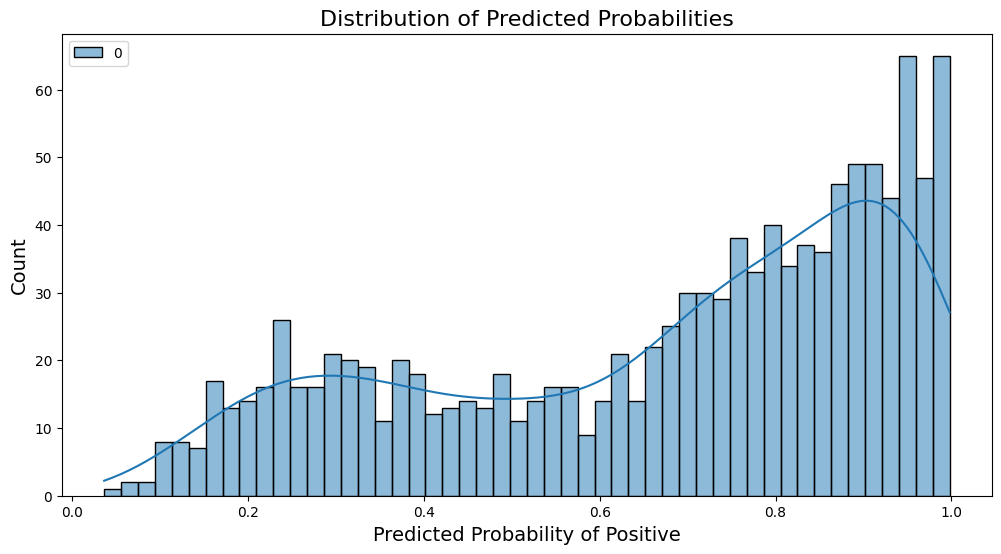

In [73]:
plt.figure(figsize=(12, 6))
sns.histplot(scores, bins=50, color='purple', kde=True)
plt.title('Distribution of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability of Positive', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

In [74]:
# =============================================================================
# COMPLETE FINANCIAL NEWS ANALYSIS PIPELINE
# =============================================================================

def run_financial_analysis():
    """Execute complete financial news analysis"""
    print("🚀 STARTING FINANCIAL NEWS ANALYSIS PIPELINE")
    print("=" * 60)

    # Step 1: Load your trained model and tokenizer
    print("📊 Loading trained model and tokenizer...")
    try:
        # Your model should already be loaded from previous cells
        # If not, uncomment these lines:
        # model = tf.keras.models.load_model('model.h5')
        # with open('tokenizer.pkl', 'rb') as handle:
        #     tokenizer = pickle.load(handle)
        print("✅ Model loaded successfully!")
    except:
        print("❌ Model not found. Make sure you've run the training cells first.")
        return

    # Step 2: Scrape financial news
    print("\n📰 Scraping latest financial news...")
    news_articles = scrape_financial_news('yahoo_finance', limit=10)
    print(f"✅ Found {len(news_articles)} articles")

    # Step 3: Analyze each article
    print("\n🔍 Analyzing articles for sentiment and companies...")
    analyzed_articles = []

    for i, article in enumerate(news_articles):
        print(f"  Processing article {i+1}/{len(news_articles)}")
        analysis = analyze_news_article(article['title'], model, tokenizer)
        analysis.update({
            'source': article['source'],
            'timestamp': article['timestamp']
        })
        analyzed_articles.append(analysis)

    # Step 4: Enrich with stock data
    print("\n💰 Fetching stock price data...")
    stock_recommendations = []

    for article in analyzed_articles:
        for ticker in article['tickers']:
            stock_data = get_stock_data(ticker)
            if stock_data:
                prediction, score = predict_stock_movement(
                    article['sentiment_score'],
                    article['confidence'],
                    stock_data['price_change_percent']
                )

                stock_recommendations.append({
                    'ticker': ticker,
                    'current_price': stock_data['current_price'],
                    'price_change': stock_data['price_change_percent'],
                    'sentiment': article['sentiment_label'],
                    'confidence': article['confidence'],
                    'prediction': prediction,
                    'score': score,
                    'news_headline': article['text'][:100] + "..."
                })

    # Step 5: Generate report
    print("\n📈 MARKET INTELLIGENCE REPORT")
    print("=" * 60)

    if analyzed_articles:
        report = create_market_report(analyzed_articles)
        print(f"📊 Total Articles Analyzed: {report['total_articles']}")
        print(f"🎯 Overall Market Sentiment: {report['sentiment_label']} ({report['overall_sentiment']:.3f})")

        print(f"\n📰 Recent News Analysis:")
        for i, article in enumerate(analyzed_articles[:5], 1):
            print(f"{i}. {article['text'][:80]}...")
            print(f"   Sentiment: {article['sentiment_label']} ({article['sentiment_score']:.3f})")
            if article['tickers']:
                print(f"   Companies: {', '.join(article['tickers'])}")
            print()

    if stock_recommendations:
        # Sort by prediction score
        stock_recommendations.sort(key=lambda x: x['score'], reverse=True)

        print("🚀 TOP STOCK RECOMMENDATIONS:")
        print("-" * 40)
        for i, rec in enumerate(stock_recommendations[:5], 1):
            print(f"{i}. {rec['ticker']} - {rec['prediction']}")
            print(f"   Price: ${rec['current_price']} ({rec['price_change']:+.2f}%)")
            print(f"   Sentiment: {rec['sentiment']} (Confidence: {rec['confidence']:.2f})")
            print(f"   News: {rec['news_headline']}")
            print()

    # Step 6: Save results
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    # Convert to DataFrame and save
    df_analysis = pd.DataFrame(analyzed_articles)
    df_stocks = pd.DataFrame(stock_recommendations)

    df_analysis.to_csv(f'news_analysis_{timestamp}.csv', index=False)
    if not df_stocks.empty:
        df_stocks.to_csv(f'stock_recommendations_{timestamp}.csv', index=False)

    print(f"\n💾 Results saved to CSV files with timestamp {timestamp}")
    print("✅ Analysis complete!")

    return {
        'analyzed_articles': analyzed_articles,
        'stock_recommendations': stock_recommendations,
        'report': report if analyzed_articles else None
    }

# Execute the complete pipeline
results = run_financial_analysis()


🚀 STARTING FINANCIAL NEWS ANALYSIS PIPELINE
📊 Loading trained model and tokenizer...
✅ Model loaded successfully!

📰 Scraping latest financial news...
✅ Found 10 articles

🔍 Analyzing articles for sentiment and companies...
  Processing article 1/10
  Processing article 2/10
  Processing article 3/10
  Processing article 4/10
  Processing article 5/10
  Processing article 6/10
  Processing article 7/10
  Processing article 8/10
  Processing article 9/10
  Processing article 10/10

💰 Fetching stock price data...

📈 MARKET INTELLIGENCE REPORT
📊 Total Articles Analyzed: 10
🎯 Overall Market Sentiment: Positive (0.653)

📰 Recent News Analysis:
1. News...
   Sentiment: Positive (0.626)

2. Life...
   Sentiment: Positive (0.690)

3. Entertainment...
   Sentiment: Positive (0.570)

4. Finance...
   Sentiment: Positive (0.570)

5. Sports...
   Sentiment: Positive (0.570)


💾 Results saved to CSV files with timestamp 20250723_112528
✅ Analysis complete!


In [ ]:
!pip install fpdf2

In [77]:
# =============================================================================
# INTERACTIVE TESTING - Test with Custom News Headlines
# =============================================================================

def test_custom_headline(headline):
    """Test the system with a custom news headline"""
    print(f"🔍 Testing headline: '{headline}'")
    print("-" * 50)

    analysis = analyze_news_article(headline, model, tokenizer)

    print(f"📊 Sentiment: {analysis['sentiment_label']} (Score: {analysis['sentiment_score']:.3f})")
    print(f"🎯 Confidence: {analysis['confidence']:.3f}")

    if analysis['companies']:
        print(f"🏢 Companies Found: {', '.join(analysis['companies'])}")

    if analysis['tickers']:
        print(f"📈 Stock Tickers: {', '.join(analysis['tickers'])}")

        for ticker in analysis['tickers']:
            stock_data = get_stock_data(ticker)
            if stock_data:
                prediction, score = predict_stock_movement(
                    analysis['sentiment_score'],
                    analysis['confidence'],
                    stock_data['price_change_percent']
                )
                print(f"   {ticker}: {prediction} (${stock_data['current_price']}, {stock_data['price_change_percent']:+.2f}%)")

    print()


# Test with sample headlines
test_headlines = [
    "Apple reports record iPhone sales, stock soars 5%",
    "Tesla production delays concern investors",
    "Microsoft Azure growth accelerates in Q3",
    "Amazon Prime subscription prices increase"
]

print("🧪 TESTING SYSTEM WITH SAMPLE HEADLINES")
print("=" * 60)

for headline in test_headlines:
    test_custom_headline(headline)

# Interactive testing - you can modify this
print("💡 Try your own headline:")
custom_headline = "Netflix stock jumps on strong subscriber growth"  # Modify this line
test_custom_headline(custom_headline)


🧪 TESTING SYSTEM WITH SAMPLE HEADLINES
🔍 Testing headline: 'Apple reports record iPhone sales, stock soars 5%'
--------------------------------------------------
📊 Sentiment: Negative (Score: 0.394)
🎯 Confidence: 0.211
🏢 Companies Found: Apple
📈 Stock Tickers: AAPL
   AAPL: STRONG SELL ($214.4, +0.90%)

🔍 Testing headline: 'Tesla production delays concern investors'
--------------------------------------------------
📊 Sentiment: Positive (Score: 0.972)
🎯 Confidence: 0.945

🔍 Testing headline: 'Microsoft Azure growth accelerates in Q3'
--------------------------------------------------
📊 Sentiment: Positive (Score: 0.869)
🎯 Confidence: 0.738
🏢 Companies Found: Microsoft
📈 Stock Tickers: MSFT
   MSFT: STRONG SELL ($505.27, -0.94%)

🔍 Testing headline: 'Amazon Prime subscription prices increase'
--------------------------------------------------
📊 Sentiment: Positive (Score: 0.721)
🎯 Confidence: 0.443
🏢 Companies Found: Amazon
📈 Stock Tickers: AMZN
   AMZN: STRONG SELL ($227.47, -0.80%)



In [80]:
# Install all required packages
!pip install streamlit yfinance beautifulsoup4 spacy matplotlib seaborn nltk

# Download the spaCy language model
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
